In [34]:
%pylab inline
import numpy as np
import pylab as pl
#import kmseg
import sklearn.cluster
from sklearn import mixture
from scipy.cluster.vq import kmeans2
import random
random.seed((1000,2000))

kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

import json
import os
s = json.load( open(os.getenv ('PUI2015')+"/fbb_matplotlibrc.json") )
pl.rcParams.update(s)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


##Tasks:
IMPORTANT: we talked about the importance of "whitening" your data: dividing each feature by its standard deviation. Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix. Whitening your data in time series analysis is in most cases wrong: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps
mydata.shape should be (Nzipcodes, Ntimestamps)
mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))
mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))
TASKS:
1. get and prep your data.
2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
4. Use another clustering algorithm (of your choice)
5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
6. Compare the results of the 2 algorithms
7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 

###County business pattern data by zipcode is downloaded from 
http://www.census.gov/econ/cbp/download/

###zipcode file is downloaded from 
http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981


In [35]:
#Loading the zipcode geo data
import urllib2

url = "https://nycdatastables.s3.amazonaws.com/2013-08-19T18:18:28.877Z/nyc-zip-code-tabulation-areas-polygons.geojson"
request = urllib2.urlopen(url)
zipcode = json.load(request)

nyczip = []
for i in range (0,262):
    nyczip.append(str(zipcode['features'][i]['properties']['postalCode']))

print "Number of Zipcode:", len(nyczip)
print ""
print nyczip

Number of Zipcode: 262

['11372', '11004', '11040', '11426', '11365', '11373', '11001', '11375', '11427', '11374', '11366', '11423', '11428', '11432', '11379', '11429', '11435', '11415', '11418', '11433', '11451', '11221', '11421', '11419', '11434', '11216', '11416', '11233', '11436', '11213', '11212', '11225', '11218', '11226', '11219', '11210', '11230', '11204', '10471', '10470', '10466', '10467', '10463', '10475', '10464', '10469', '10468', '10463', '10458', '10034', '10033', '10462', '10040', '10453', '10465', '10464', '10464', '10461', '10457', '10460', '10032', '10452', '10456', '10472', '10031', '10039', '10459', '10451', '10473', '10030', '10027', '10474', '10455', '10037', '10024', '10454', '10026', '10035', '10025', '10035', '11357', '10029', '00083', '11356', '11359', '11360', '11105', '10128', '11371', '10023', '11363', '10028', '11354', '11102', '11370', '10021', '11361', '11358', '11362', '10044', '11369', '11103', '11106', '11368', '11377', '10036', '11355', '11101', '11

In [37]:
#To read in a zip file without unzipping it, we can use the pandas and zipfile packages
import pandas as pd
import zipfile #if used only once, don't have to give a name

#Data is from 1994 to 2013
#format is different in 1998-2002 (header is upper case)

qw = {}
for i in range (1994,2014):
    if i in range(1998, 2003):
        fname = 'zbp' + str(i)[2:] +'totals.zip'
        #print fname
        zf = zipfile.ZipFile(fname)
        df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
        df = df.rename(columns={'ZIP': 'zip', 'EST': str(i)})
        df = df[(df.zip.astype(str).isin(nyczip))]
        qw['{}'.format(i)] = df[['zip',str(i)]]
    else:
        fname = 'zbp' + str(i)[2:] +'totals.zip'
        #print fname
        zf = zipfile.ZipFile(fname)
        df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
        df = df.rename(columns={'est': str(i)})
        df = df[(df.zip.astype(str).isin(nyczip))]
        qw['{}'.format(i)] = df[['zip',str(i)]]
        
#Merge the data based on zipcode
dfs = [qw['1994'], qw['1995'], qw['1996'], qw['1997'], qw['1998'],qw['1999'],qw['2000'],qw['2001'],qw['2002'],qw['2003'],qw['2004'],qw['2005'],qw['2006'],qw['2007'],qw['2008'],qw['2009'],qw['2010'],qw['2011'],qw['2012'],qw['2013'],]
df_final = reduce(lambda left,right: pd.merge(left,right,on='zip', how = 'inner'), dfs)
df_final = df_final.set_index('zip')
print "Sanity Check: Shape of the dataframe:", df_final.shape
print ""
print df_final.head()

Sanity Check: Shape of the dataframe: (230, 20)

       1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  2005  \
zip                                                                             
10001  6999  7088  7075  7154  7254  7233  7317  7188  7141  7084  7370  7312   
10002  1784  1819  1919  2049  2003  2085  2277  2543  2269  2402  2551  2682   
10003  3256  3377  3417  3535  3649  3659  3683  3602  3616  3704  3776  3867   
10004  1115  1124  1133  1173  1176  1233  1294  1247  1253  1252  1283  1260   
10005  1076  1109  1216  1227  1270  1242  1287  1249  1244  1200  1226  1214   

       2006  2007  2008  2009  2010  2011  2012  2013  
zip                                                    
10001  7415  7549  7472  7305  7241  7227  7235  7273  
10002  2686  2685  2691  2775  2872  2912  2954  2988  
10003  3909  4049  4071  4099  4113  4159  4214  4277  
10004  1311  1370  1376  1379  1398  1404  1442  1479  
10005  1259  1273  1291  1274  1266  1301  1273

Sanity Check
mean: 0.00
std: 1.0


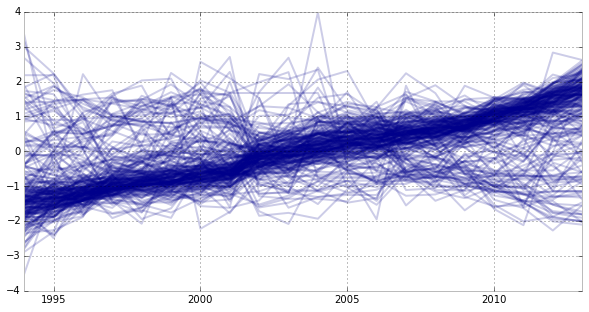

In [41]:
#subtract the mean and divide each time series (separately) by its standard deviation.

df_final = df_final.dropna()

mydata = df_final
for i in range(len(mydata)):
    mydata.iloc[i] = (mydata.iloc[i]-np.mean(mydata.iloc[i]))/np.std(mydata.iloc[i])

#print mydata.head()
dbb = mydata.copy()
#print dbb.head()
print "Sanity Check"
print "mean:", ("{0:.2f}".format(np.mean(mydata.iloc[i])))
print "std:", np.std(mydata.iloc[i])

pl.figure(figsize=(10,5))
pl.xlim(1994,2013)
for i in range(len(mydata)):
    pl.plot(mydata.iloc[i].index, mydata.iloc[i],'darkblue', alpha=0.2) 

##Method 1: kmeans2
http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.vq.kmeans2.html

returns c

entroid : ndarray - A ‘k’ by ‘N’ array of centroids found at the last iteration of k-means.

label : ndarray - label[i] is the code or index of the centroid the i’th observation is closest to.


[-1.40034889 -1.29929579 -1.16735749 -0.97071019 -0.85377202 -0.75234121
 -0.63077269 -0.55982081 -0.17557255 -0.01060575  0.20365377  0.33077561
  0.37520965  0.53406493  0.62572175  0.7290357   0.95909309  1.12857338
  1.33900685  1.59546265] [0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0
 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0] (230,)


(1994, 2013)

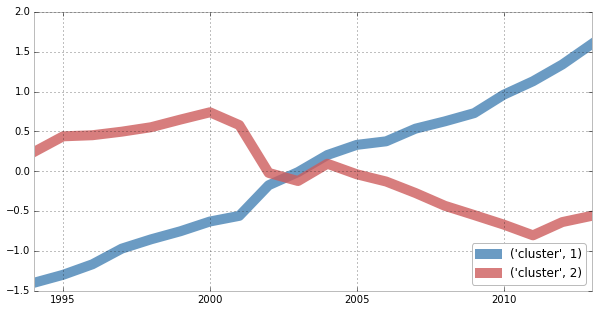

In [42]:
# k means cluster results depend on the starting point, which is random!
random.seed((1000,2000))

#When use kmeans2, mydata needs to be convert to np.asarray, minit needs to change to points
#otherwise it will give an error of matrix is not positive definite

#Try 2 cluster first
mydata2= mydata
nk= 2
centroids_2, label_2 = kmeans2(np.asarray(mydata2), 2, iter=20, minit = 'points')

year = np.arange(1994,2014)
print centroids_2[0], label_2, label_2.shape
pl.figure(figsize=(10,5))
for i in range(len(centroids_2)):
    pl.plot(year, centroids_2[i], alpha=0.8, linewidth=10, label=('cluster',i+1)) 
pl.legend(loc=4)
pl.xlim(1994,2013)


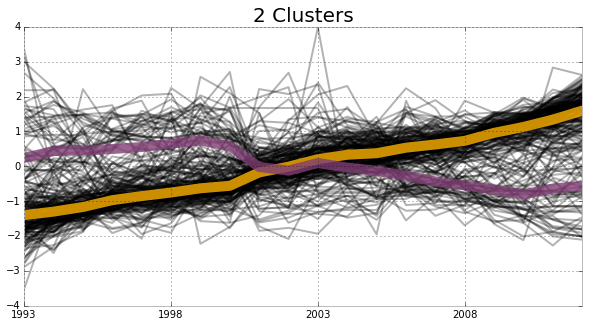

In [44]:
#add cluster number to my data
mydata2['cluster']=label_2

#plot the cluster over the original data
fig = pl.figure(figsize=(10,5))
#ax = []
ax = fig.add_subplot(1,1,1)
#for i in range(len(centroids)):
#    ax.append(fig.add_subplot(len(centroids),1,i+1))
for i in range(len(mydata2)):
    cluster = int(mydata2.cluster.iloc[i])
    pl.plot(mydata2.iloc[i],'k', alpha = 0.3)
for i in range(len(centroids_2)):
    pl.plot(centroids_2[i], alpha=0.8, linewidth=10, color=kelly_colors_hex[i], label=('cluster',i)) 
pl.xlim(0,19)
ax.set_xticklabels(['1993', '1998', '2003', '2008'])    
pl.title('2 Clusters', size=20)

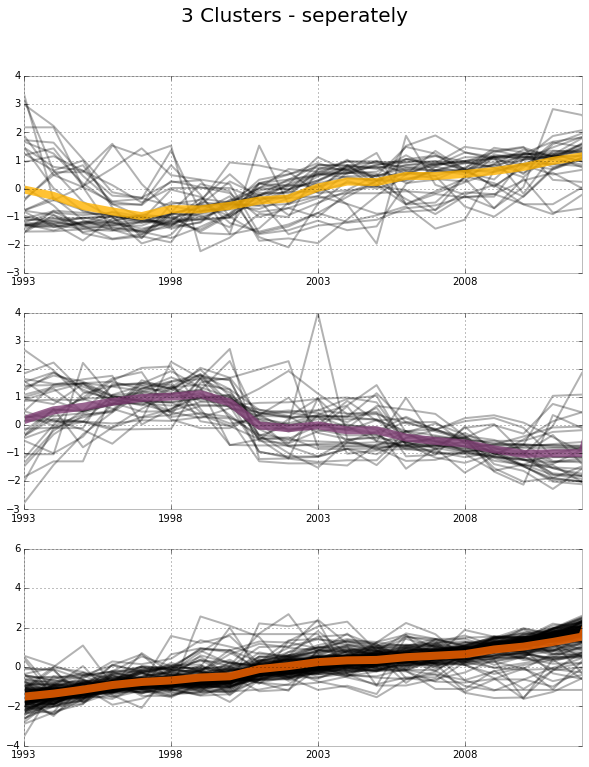

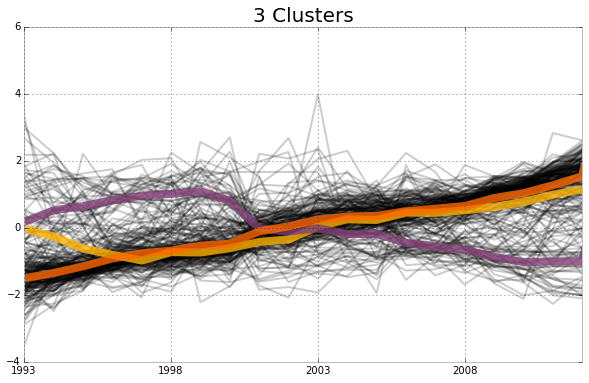

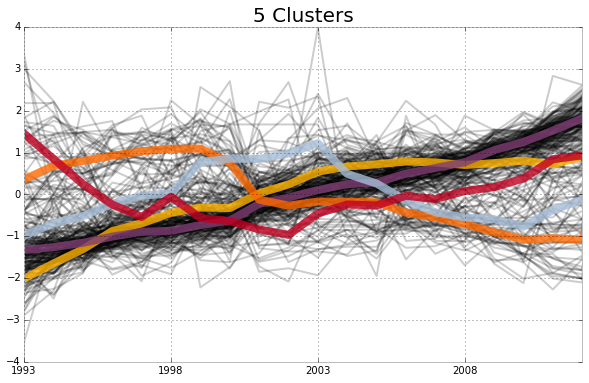

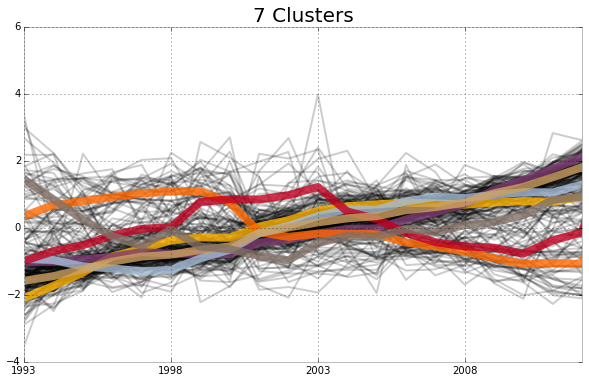

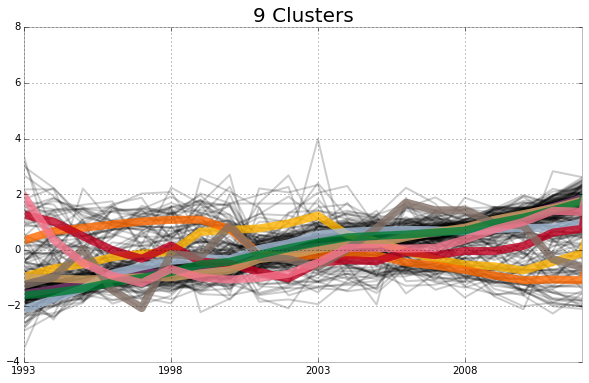

In [46]:
#3 clusters
random.seed((1000,2000))

mydata3= mydata
nk= 3
centroids_3, label_3 = kmeans2(np.asarray(mydata3), nk, iter=20, minit = 'points')
mydata3['cluster']=label_3

#plot the clusters seperately
fig = pl.figure(figsize=(10,12))
ax = []
for i in range(len(centroids_3)):
    ax.append(fig.add_subplot(len(centroids_3),1,i+1))
for i in range(len(mydata3)):
    cluster = int(mydata3.cluster.iloc[i])
    ax[cluster].plot(mydata3.iloc[i],'k', alpha = 0.3)
for i in range(len(centroids_3)):
    ax[i].plot(centroids_3[i], alpha=0.8, linewidth=8, color=kelly_colors_hex[i], label=('cluster',i)) 
    ax[i].set_xlim(0,19)
    ax[i].set_xticklabels(['1993', '1998', '2003', '2008'])   
pl.suptitle('3 Clusters - seperately', size=20)


#plot the cluster over the original data
fig = pl.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
for i in range(len(mydata3)):
    cluster = int(mydata3.cluster.iloc[i])
    pl.plot(mydata3.iloc[i],'k', alpha = 0.2)
for i in range(len(centroids_3)):
    pl.plot(centroids_3[i], alpha=0.8, linewidth=8, color=kelly_colors_hex[i], label=('cluster',i)) 
pl.xlim(0,19)
ax.set_xticklabels(['1993', '1998', '2003', '2008'])    
pl.title('3 Clusters', size=20)

#5 clusters
mydata5= mydata
nk= 5
centroids_5, label_5 = kmeans2(np.asarray(mydata5), nk, iter=20, minit = 'points')
mydata5['cluster']=label_5

#plot the cluster over the original data
fig = pl.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
for i in range(len(mydata5)):
    cluster = int(mydata5.cluster.iloc[i])
    pl.plot(mydata5.iloc[i],'k', alpha = 0.2)
for i in range(len(centroids_5)):
    pl.plot(centroids_5[i], alpha=0.8, linewidth=8, color=kelly_colors_hex[i], label=('cluster',i)) 
pl.xlim(0,19)
ax.set_xticklabels(['1993', '1998', '2003', '2008'])    
pl.title('5 Clusters', size=20)

#7 clusters
mydata7= mydata
nk= 7
centroids_7, label_7 = kmeans2(np.asarray(mydata7), nk, iter=20, minit = 'points')
mydata7['cluster']=label_7

#plot the cluster over the original data
fig = pl.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
for i in range(len(mydata7)):
    cluster = int(mydata7.cluster.iloc[i])
    pl.plot(mydata7.iloc[i],'k', alpha = 0.2)
for i in range(len(centroids_7)):
    pl.plot(centroids_7[i], alpha=0.8, linewidth=8, color=kelly_colors_hex[i], label=('cluster',i)) 
pl.xlim(0,19)
ax.set_xticklabels(['1993', '1998', '2003', '2008'])    
pl.title('7 Clusters', size=20)

#9 clusters
mydata9= mydata
nk= 9
centroids_9, label_9 = kmeans2(np.asarray(mydata9), nk, iter=20, minit = 'points')
mydata9['cluster']=label_9

#plot the cluster over the original data
fig = pl.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
for i in range(len(mydata9)):
    cluster = int(mydata9.cluster.iloc[i])
    pl.plot(mydata9.iloc[i],'k', alpha = 0.2)
for i in range(len(centroids_9)):
    pl.plot(centroids_9[i], alpha=0.8, linewidth=8, color=kelly_colors_hex[i], label=('cluster',i)) 
pl.xlim(0,19)
ax.set_xticklabels(['1993', '1998', '2003', '2008'])    
pl.title('9 Clusters', size=20)

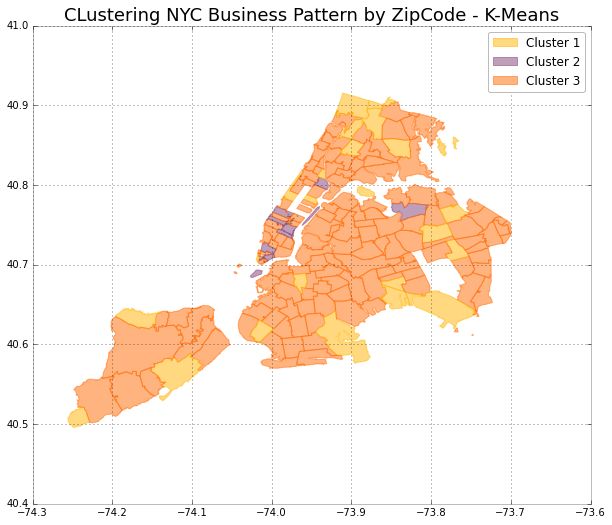

In [48]:
#Read the map data
import geopandas as gp

NYCmap = gp.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')
NYCmap.rename(columns = {'postalCode':'zip'}, inplace=True)

mydata_zip = mydata3
mydata_zip['zip']=mydata_zip.index

#print NYCmap.head()
#print mydata_zip.head()
NYCmap['zip'] = NYCmap['zip'].astype(float)
mydata_ks = pd.merge(mydata_zip, NYCmap, on = 'zip', how = 'inner')
#print mydata2.head()

#Plot K-means
from descartes import PolygonPatch
import matplotlib.patches as mpatches

Kmeans_3cluster = mydata_ks.join(pd.Series(label_3, name = 'Cluster'))
Kmeans_3cluster = Kmeans_3cluster.dropna()
#print plotKmeans.head

fig = plt.figure(figsize=(10,10))

for i in range(len(Kmeans_3cluster)):
    ax = fig.add_subplot(111)
    #get polygon x, y coordinates
    polygon = Kmeans_3cluster['geometry'][i]
    cluster = Kmeans_3cluster['Cluster'][i]
    ax.add_patch(PolygonPatch(polygon, fc=kelly_colors_hex[int(cluster)], ec=kelly_colors_hex[int(cluster)], alpha=0.5, label=i))
ax.axis('scaled')
ax.set_title('CLustering NYC Business Pattern by ZipCode - K-Means', size=18)
#Add legend
p1 = mpatches.Patch(color=kelly_colors_hex[0], alpha=0.5)
p2 = mpatches.Patch(color=kelly_colors_hex[1], alpha=0.5)
p3 = mpatches.Patch(color=kelly_colors_hex[2], alpha=0.5)
pl.legend((p1,p2,p3,), ('Cluster 1', 'Cluster 2', 'Cluster 3'))


##Method 2: DBscan

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html


In [75]:
from sklearn.cluster import DBSCAN

#the max distance eps can be modified to more realistic distance related to neighborhood size.
#print mydata.head()

#print dbb.head()
x = dbb
#something wierd happens.. there's a zip column which should not exist there, so I try to drop it
try:
    x = x.drop('zip', axis=1, inplace=True)
    #x = x.dropna()
except ValueError:
    x = x 
db = DBSCAN(eps=1.8, min_samples=2).fit(x)

labels_db = (db.labels_).astype(int)
num_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
#clusters_db = pd.Series([mydata[labels_db == i] for i in xrange(num_clusters)])
print('Number of clusters: %d' % num_clusters)

Number of clusters: 4


In [85]:
print labels_db

clusters_db = db.labels_+2

#print clusters_db

[-1  0  0  0 -1  1 -1  0 -1  0  0 -1  0 -1  2 -1 -1 -1  3 -1  0  0  0  0  0
  0  0  0  0  0  0  0  0 -1  0 -1  0  0  0 -1  0 -1 -1 -1  3 -1 -1 -1 -1  2
 -1 -1 -1  3  0 -1  1  2 -1  0 -1  3 -1 -1 -1 -1 -1  3 -1  0 -1 -1 -1  0 -1
  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2  0  2  0  0  0  0  0  0  0  0  0  0 -1
  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0 -1  0  0  0  0  0 -1 -1  0  0
  0  0 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0 -1
  0  0  0  0  0 -1 -1  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 -1  0  0  0  0  0  0  0 -1  0 -1  0  0  0 -1  0  0  0  0  0 -1
  0 -1  0  0 -1]


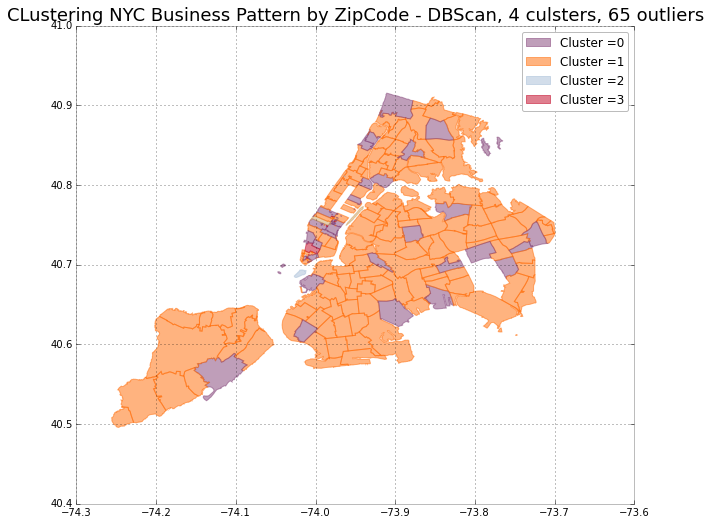

In [84]:
#Read the map data

db_zip = pd.DataFrame({'zip':df_final.index,'cluster':clusters_db})

NYCmap['zip'] = NYCmap['zip'].astype(float)
mydata_db = pd.merge(db_zip, NYCmap, on = 'zip', how = 'inner')
#print mydata_db.head()

#Plot dbscan
from descartes import PolygonPatch
import matplotlib.patches as mpatches

db_plot = mydata_db.join(pd.Series(clusters_db, name = 'Cluster'))
db_plot = db_plot.dropna()
#print plotKmeans.head

fig = plt.figure(figsize=(10,10))

for i in range(len(db_plot)):
    ax = fig.add_subplot(111)
    #get polygon x, y coordinates
    polygon = db_plot['geometry'][i]
    cluster = db_plot['Cluster'][i]
    ax.add_patch(PolygonPatch(polygon, fc=kelly_colors_hex[int(cluster)], ec=kelly_colors_hex[int(cluster)], alpha=0.5, label=i))
ax.axis('scaled')
ax.set_title("CLustering NYC Business Pattern by ZipCode - DBScan, %d culsters, %d outliers"%(num_clusters, sum(labels_db == -1)), size=18)
#Add legend
p1 = mpatches.Patch(color=kelly_colors_hex[1], alpha=0.5)
p2 = mpatches.Patch(color=kelly_colors_hex[2], alpha=0.5)
p3 = mpatches.Patch(color=kelly_colors_hex[3], alpha=0.5)
p4 = mpatches.Patch(color=kelly_colors_hex[4], alpha=0.5)
pl.legend((p1,p2,p3,p4), ('Cluster =0', 'Cluster =1', 'Cluster =2','Cluster =3'))

##Compare the results of 2 algorithms

It's hard to say which one is better. K means cluster is really easy to apply, however its results depend on the starting point, which is random. (though I tried to fix it with a random state..) The results might be very different every time we run it. So the results are somehow not reproductible. It also requires an initial 'guess' of the number of clusters.

DBSCAN Algorithm is a density-based algorithm, the advantage is that I don't need to specify the number of clusters.  It is robust to outliers, but may not be that good for this dataset that 65 out of 230 are outliers when I tested it. It might be a bit complicated on finding the right distance too.


##Attempt an interpretation

-For Kmeans clusters

From 1994 to 2013, the number of establishments are increasing every year for most parts of New York City (cluster 3, orange color). Some of the areas has a decreasing number of establishments before 1997, and the number increases since then (Cluster 1, yellow color). One interseting finding is that most of these areas has public park inside. Further analysis will be required to identify that if park has an impact on the number of establishments surround. The purple areas have more viarations in terms of the number of establishments, but the overall trend is slightly decreasing. Those areas includes some zipcodes location in midtown, downtown and flushing area in Queens. Midtown and downtown Manhattan has been developed earlier than other areas in NYC, so it is understandable that the total number of establishment didn't increase a lot. FLushing seems to be an exception though, because many developments happens there right now. Futher analysis will be needed for this area (maybe the recent developments starts after 2013?).

-For DBscan clusters

Again, midtown and downtown Manhattan are in a different pattern (in purple). Also, most of the other purple areas in Queens/Brooklyn seem to lack access of subway. Further analysis will be needed to see if there's a relationship between them. SOHO area (dark purple) and Governer's island (light blue) seem to have two seperate patterns other than all of the areas mentioned before . 

